In [134]:
# coding: utf-8
#from __future__ import print_function
import pandas as pd
from datetime import datetime
import numpy as np
import csv
from PIL import Image, ImageDraw, ImageFont
import sys
import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

__version__ = "1.03"

In [135]:
class SaikyoABC(object):
    u"""西京中学プロジェクト：答案データ(Answer Box Creater)処理用クラス
    
    SaikyoABC(ファイル名)で、ファイル名で指定したCSVファイルを読み込んだインスタンスを生成します。
    
    -------
    - start_time : 回答開始時刻
    - end_time : 回答終了時刻
    - stroke : ストロークデータ（pandasのDataFrame）
        - stroke.PENTYPE : ペンタイプ（STYLUS, ERASEPEN, NAMEのいずれか）
        - stroke.PENWIDTH : ペンの太さ（int型)
        - stroke.Timestamp : そのストロークが書き始められた時刻
        - stroke.STROKE : np.arrayで与えられるストローク座標データ
        
    以下で出力されるインスタンス変数、メソッドの内、以降のデータ解析に用いられるものについては
    Compare_answersの中で説明しているのでそちらを参照してください。
    """
        
    def __init__(self,filename,true_or_false):
        self.true_or_false = true_or_false
        if filename is not None:
            self.read_stroke_csv(filename)
    
    
    def read_stroke_csv(self, filename):
        u"""ストロークが入ったCSVファイルを読み込む。
        -----
        input:
            filename: ファイル名（strokes.csv）
        """
        self.filename = filename
        self.true_or_false = 1
        u"""filenameの答案が正解しているなら２三角なら１間違いなら０"""
        
        # ストロークが入ったCSVファイルを読み込みます．ただし，最初の行と最後の行は読み込みません．
        df = pd.read_csv(filename,header=None,skiprows=1,skipfooter=1,engine='python')
        df.columns = ["Date","Time","MODE","PEN","UNKNOWN","STROKE","STROKE_NUM"]
        # 時刻情報をpythonのdatetimeオブジェクトに変換します．（そうすると時刻の引き算が簡単になるので）
        df = df.assign(Timestamp = [datetime.strptime(row.Date+" "+row.Time, "%Y/%m/%d %H:%M:%S.%f") for row in df.itertuples()] )
        
        # ペンの色とかはどうでもいいので，ペンタイプ（スタイラス or 消しゴム）とペン（もしくは消しゴム）の太さの情報のみを残します．
        df = df.assign(PENTYPE = [d.split()[0] for d in df.PEN])
        penwidth = [d.split()[2] for d in df.PEN]
        df = df.assign(PENWIDTH = [int(d.split(";")[0]) for d in penwidth])
        
        
        # ストロークデータをnumpyの2次元配列に変換．
        stroke = [d.split() for d in df.STROKE]
        def toNumpy(stroke):
            return np.array([s.split(":") for s in stroke],dtype=np.int).T
        df.STROKE = [toNumpy(s) for s in stroke]
 
        
        # ストロークの座標が-1になっているやつは，名前欄に記入したストロークなので，ペンタイプをNAMEにしておく．
        df.loc[ [np.min(s)<0 for s in df.STROKE], "PENTYPE" ] = "NAME"

        # 不要な列を削除
        del df['Date']
        del df['Time']
        del df['MODE']
        del df['UNKNOWN']
        del df['PEN']
        del df['STROKE_NUM']
        
        self.stroke = df
        u"""
        #csvファイルを標準出力
        print(df.columns)
        df.to_csv(sys.stdout)
        """
        
        # 解答開始時刻（csvファイルの1行目）と終了時刻（csvファイルの最終行)を計算する．
        f = open(filename,'r')
        dataReader = csv.reader(f)
        
        u"""
        first = dataReader.next()
        #下に変更したので注意！！
        """
        
        #ヘッダーを読み飛ばす
        first = next(dataReader)  
        
        for last in dataReader:
            ("")
        
        
        f.close()
        self.start_time = datetime.strptime(first[0]+" "+first[1], "%Y/%m/%d %H:%M:%S.%f")
        self.end_time = datetime.strptime(last[0]+" "+last[1], "%Y/%m/%d %H:%M:%S.%f")
        
        
    def draw_image(self,image_size=None):
        u"""ストロークデータを画像として出力する。
        -----
        input
            - image_size: 画像サイズ。(幅,高さ)で指定してください。※numpyの行列とは順番が逆なので注意！！
        """
        if image_size is None:
            image_size = np.max(np.array([np.max(s,axis=1) for s in data.stroke.STROKE]),axis=0)
        image = Image.new("RGBA",image_size,color=(255,255,255,0))
        self.__draw_image(image)
        return image
    
    
    def overlay_image(self,originalimage):
        u"""元の画像にオーバーレイする形で描画する"""
        
        background = originalimage.copy()
        background = background.convert("RGBA")
        foreground = self.draw_image(background.size)
        background.paste(foreground,(0,0),foreground)
        return background
    
    
    def __draw_image(self,image):
        draw = ImageDraw.Draw(image)
        for s,p,w in zip(self.stroke.STROKE,self.stroke.PENTYPE,self.stroke.PENWIDTH):
            if p == "STYLUS":
                draw.line(tuple(s.T.flatten()),fill=(255,0,0,128),width=w*1)
            elif p == "ERASEPEN":
                draw.line(tuple(s.T.flatten()),fill=(128,128,0,128),width=w*10)
    
    
    
    def draw_block_image(self,image_size=None):
        u"""ブロックのまとまりを画像として出力する。
        -----
        input
            - image_size: 画像サイズ。(幅,高さ)で指定してください。※numpyの行列とは順番が逆なので注意！！
        """
        if image_size is None:
            image_size = np.max(np.array([np.max(s,axis=1) for s in data.stroke.STROKE]),axis=0)
        image = Image.new("RGBA",image_size,color=(255,255,255,0))
        self.__draw_block_image(image)
        return image
    
    
    def overlay_block_image(self,originalimage):
        u"""元の画像にオーバーレイする形で描画する"""
        
        background = originalimage.copy()
        background = background.convert("RGBA")
        foreground = self.draw_block_image(background.size)
        background.paste(foreground,(0,0),foreground)
        return background
    

        
    def __draw_block_image(self,image):
        u"""
        ブロックのスケールを画像にプロットします
        """
        draw = ImageDraw.Draw(image)
        X,Y = 0,1
        xmin,xmax,ymin,ymax = 0,1,2,3
        font = ImageFont.truetype("arial.ttf", 32)
        for block_num in range(len(self.block_range)):
            X_xmin = self.block_range[block_num][X][xmin]
            Y_ymax = self.block_range[block_num][Y][ymax]
            X_xmax = self.block_range[block_num][X][xmax]
            Y_ymin = self.block_range[block_num][Y][ymin]
            draw.rectangle(((X_xmin,Y_ymax),(X_xmax,Y_ymin)),fill=(255,255,255,10),outline=(0,0,0))
            draw.text((X_xmin,Y_ymax), str(block_num) ,fill='#000',font = font)
                
                
    def __get_time_lag(self):
        u"""
        各ストローク間の時間差をnumpyに変換します。
        ペンストロークの始点から次の始点の始まりまでの時間間隔です。
        [time_lag_1,time_lag_2,time_lag_3,....]で返します。
        要素数が１つ減っているので注意。
        """
        time_lag = np.array([self.stroke.Timestamp[i+1]-self.stroke.Timestamp[i] 
                             for i in range(len(self.stroke.Timestamp) - 1)])
        return time_lag
    
    
    def __get_stroke_center(self):
        u"""
        各ストロークの中心点を定めます。
        [[Xcenter1,Ycenter1],[Xcenter2,...],....]
        の形になります。
        """
        stroke_center = np.array([[self.stroke.STROKE[stroke_num][0].mean(),self.stroke.STROKE[stroke_num][1].mean()]
                                  for stroke_num in range(len(self.stroke.STROKE))])
        return stroke_center

    
    def __get_stroke_range(self):
        u"""
        各ストロークのx座標、y座標それぞれの範囲をnumpyで返します。
        [[[x_xmin,x_xmax,x_ymin,x_ymax],[y_xmin,y_xmax,y_ymin,y_ymax]],
         [],......]
         を返します。
         stroke.range[stroke_num][XorY][(0:xmin〜3:ymaxの数字で選べます)]
        """
        X,Y = 0,1
        stroke_range = np.array([[[self.stroke.STROKE[stroke_num][X][np.argmin(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][X][np.argmax(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][X][np.argmin(self.stroke.STROKE[stroke_num][Y])],
                                   self.stroke.STROKE[stroke_num][X][np.argmax(self.stroke.STROKE[stroke_num][Y])]],
                                  [self.stroke.STROKE[stroke_num][Y][np.argmin(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][Y][np.argmax(self.stroke.STROKE[stroke_num][X])],
                                   self.stroke.STROKE[stroke_num][Y][np.argmin(self.stroke.STROKE[stroke_num][Y])],
                                   self.stroke.STROKE[stroke_num][Y][np.argmax(self.stroke.STROKE[stroke_num][Y])]]]
                                 for stroke_num in range(len(self.stroke))])
        return stroke_range
    
    
    def __get_stroke_distance(self):
        u"""
        各ストロークの終点と次の始点までの距離を返します。
        [stroke_distance_1,stroke_distance_2,.....]で返します。
        要素数が１つ減っているので注意。
        """
        stroke_distance = np.array([math.sqrt((self.stroke.STROKE[i][0][0] - self.stroke.STROKE[i+1][0][-1])**2
                                    + (self.stroke.STROKE[i][1][0] - self.stroke.STROKE[i+1][0][-1])**2)
                                    for i in range(len(self.stroke.STROKE) - 1)])
        return stroke_distance
    
    

    
            
    def __get_block_average_length(self,block_num,stroke_num):
        u"""
        特定のブロックに含まれるストロークの平均の長さを返します
        [len1,len2,....]
        の形です。
        """
        block_average_length = (self.block_average_length[block_num] + strokeLength(self.stroke.STROKE[stroke_num])) / (len(self.blocks[block_num]) + 1)
        return block_average_length
    
        
    def __get_compared_range(self,block_num,stroke_num):
        u"""
        現在見ているstrokeとそのstrokeを加えるblockのスケールを比較し、blockのスケールを更新します。
        self.block_range内に格納されます。形はstroke_classifierで説明しています。
        その後、block_numのblockのrangeを返します。
        """
        X,Y = 0,1
        xmin,xmax,ymin,ymax = 0,1,2,3
        if self.block_range[block_num][X][xmin] > self.stroke_range[stroke_num][X][xmin]:
            self.block_range[block_num][X][xmin] = self.stroke_range[stroke_num][X][xmin]
            self.block_range[block_num][Y][xmin] = self.stroke_range[stroke_num][Y][xmin]
        if self.block_range[block_num][X][xmax] < self.stroke_range[stroke_num][X][xmax]:
            self.block_range[block_num][X][xmax] = self.stroke_range[stroke_num][X][xmax]
            self.block_range[block_num][Y][xmax] = self.stroke_range[stroke_num][Y][xmax]
        if self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
            self.block_range[block_num][X][ymin] = self.stroke_range[stroke_num][X][ymin]
            self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        if self.block_range[block_num][Y][ymax] < self.stroke_range[stroke_num][Y][ymax]:
            self.block_range[block_num][X][ymax] = self.stroke_range[stroke_num][X][ymax]
            self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
        """    
        elif self.block_range[block_num][X][xmin] == self.stroke_range[stroke_num][XY][xmin]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        elif self.block_range[block_num][X][xmax] == self.stroke_range[stroke_num][X][xmax]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        elif self.block_range[block_num][X][xmin] == self.stroke_range[stroke_num][XY][xmin]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        elif self.block_range[block_num][X][xmin] == self.stroke_range[stroke_num][XY][xmin]:
            if self.block_range[block_num][X][ymax] < self.stroke_range[stroke_num][Y][ymax]:
                self.block_range[block_num][Y][ymax] = self.stroke_range[stroke_num][Y][ymax]
            elif self.block_range[block_num][Y][ymin] > self.stroke_range[stroke_num][Y][ymin]:
                self.block_range[block_num][Y][ymin] = self.stroke_range[stroke_num][Y][ymin]
        """
        
        return self.block_range[block_num]
    
    
    
    def __get_block_coordinates(self):
        u"""ブロックに分けられたストロークをポリゴンフィッティングに用いれる様に、
        bounding_box毎に各座標を全て集めた形のnumpy配列に置き換える"""
        X,Y = 0,1
        self.block_coordinates = [np.empty((0,2)) for i in range(len(self.blocks))]
        for block_num in range(len(self.blocks)):
            for stroke_num in self.blocks[block_num]:
                for coo_num in range(len(self.stroke.STROKE[stroke_num][X])):
                    self.block_coordinates[block_num] = np.append(self.block_coordinates[block_num],
                                                                  np.array([[self.stroke.STROKE[stroke_num][X][coo_num],
                                                                             self.stroke.STROKE[stroke_num][Y][coo_num]]]),axis = 0)
    
    def __get_block_coordinate(self,block_num):
        X,Y = 0,1
        for stroke_num in self.blocks[block_num]:
            for coo_num in range(len(self.stroke.STROKE[stroke_num][X])):
                self.block_coordinate = np.append(self.bock_coordinates[block_num],
                                                  np.array([[self.stroke.STROKE[stroke_num][X][coo_num],
                                                             self.stroke.STROKE[stroke_num][Y][coo_num]]]),axis = 0)
        return block_coordinate
    
    def __get_block_center(self,block_num,stroke_num):
        u"""ストロークのブロックの中心点を得ます。
        [[block1_X,block1_Y],[block2_X,...],...]
        の形で出力します。
        """
        X,Y = 0,1
        self.block_center[block_num][X] = (self.block_center[block_num][X] * len(self.blocks[block_num]) + self.stroke_center[stroke_num][X]) / (len(self.blocks[block_num]) + 1)
        self.block_center[block_num][Y] = (self.block_center[block_num][Y] * len(self.blocks[block_num]) + self.stroke_center[stroke_num][Y]) / (len(self.blocks[block_num]) + 1)        
        return self.block_center[block_num]
    
    
    def __check_included(self,block_num,stroke_num):
        u"""
        stroke_numのストロークがblock_numのブロックに含まれるかを判定する関数です。
        含まれるなら１を、含まれないなら０を返します。
        """
        distance = 0
        u"""
        stroke_numのstrokeがblock_numのブロックに含まれるかを判定する評価尺度。
        大きいほどblock_numのブロックに含まれる可能性が小さくなります。
        """
        threshhold = 25
        u"""閾値"""
        
        X,Y = 0,1
        
        w_time_lag = 1/2
        w_stroke_range = 1
        w_stroke_length = 1/100
        w_stroke_distance = 1/1000
        w_block_range = 1
        w_block_average_length = 1
        w_length_compare = 1/5
        w_distance_stroke_block = 1/4
        
        average_stroke_distance = 0
        for avenum in self.blocks[block_num]:
            average_stroke_distance += self.stroke_distance[avenum]
        average_stroke_distance /= len(self.blocks[block_num])
        
        time_lag = self.time_lag[stroke_num - 1]
        u"""ストロークが引かれるまでの時間間隔"""
        if time_lag.days >= 1:
            time_lag = 5
        else:
            time_lag = time_lag.seconds + time_lag.microseconds / (10**6)
           
        distance_stroke_block = math.sqrt((self.block_center[block_num][X] - self.stroke_center[stroke_num][X])**2 
                                          + (self.block_center[block_num][Y] - self.stroke_center[stroke_num][Y])**2)
        u"""ブロックとストロークとの距離"""
        length_compare = math.sqrt((strokeLength(self.stroke.STROKE[stroke_num]) - self.block_average_length[block_num])**2)
        u"""ストロークの平均の長さとの差"""
        block_size = (self.block_range[block_num][X][1] - self.block_range[block_num][X][0])*(self.block_range[block_num][Y][3] - self.block_range[block_num][Y][2])
        d1 = (w_time_lag * time_lag * w_stroke_distance * self.stroke_distance[stroke_num - 1])
        d2 = (w_distance_stroke_block * distance_stroke_block) * (1/2 +  1/block_size)
        d3 = (w_length_compare * length_compare)
        d4 = (w_stroke_length * strokeLength(self.stroke.STROKE[stroke_num]))
        distance = d1 + d2 + d3 + d4
        """
        print("---------------------------------------------------------------------------------")
        print(self.time_lag[stroke_num - 1])
        print('timelag:{0}'.format(time_lag))
        print('distance_stroke_block:{0}'.format(distance_stroke_block))
        print('block_size:{0}'.format(block_size))
        print('length_compare:{0}'.format(length_compare))
        print('distance:{0}'.format(distance))
        print('AverageStrokeDistance:{0}'.format(average_stroke_distance))
        print(d1)
        print(d2)
        print(d3)
        print(d4)
       """
        if distance < threshhold:
            return 1
        else:
            return 0                                       

        
        
    def stroke_classifier(self):
        u"""
        各ストロークをストロークのクラスタblocksに分類していく関数です。
        self.stroke.STROKE[stroke_num]でが取り出せる。
        """
        X,Y = 0,1
        xmin,xmax,ymin,ymax = 0,1,2,3
        self.time_lag = self.__get_time_lag()
        self.stroke_range = self.__get_stroke_range()
        self.stroke_distance = self.__get_stroke_distance()
        self.stroke_center = self.__get_stroke_center()
        self.blocks = [[]]
        u"""
        blocks:[[stroke_num1,stroke_num2,...],[stroke_numA,stroke_numB,...],...]
        の形になっています。
        """
        self.block_range = [[]]
        u"""
        block_range:[[[x_xmin_block1,x_xmax_block1,x_ymin_block1,x_ymax_block1],[y_xmin_block1,...]],
                     [[],[]],...]
                     の形になっています。
        block_range[block_num][XorY][select(min_or_max)of(XorY)(要素の順番は上記の通り)]
        """
        self.block_center = [0]
        u"""
        各ブロックの中心点を定めます。
        [[Xcenter1,Ycenter1],[Xcenter2,...],...]
        の形です。
        """
        self.block_average_length = [0]
        block_num = 0
        
        for stroke_num in range(len(self.stroke)) :
            if self.stroke.STROKE[stroke_num][0][0] == -1:
                pass
            elif len(self.blocks[block_num]) == 0 :
                u"""
                ブロックが空の時は、現在のブロックに対する評価が出来ないため念のため最初の処理は分けています。
                np.empty()を使えば良かったみたいですね・・・。
                """
                self.blocks = [[stroke_num]]
                self.block_range = [self.stroke_range[stroke_num]]
                self.block_average_length[0] = strokeLength(self.stroke.STROKE[stroke_num])
                self.block_center[0] = self.stroke_center[stroke_num]
            else:
                if self.__check_included(block_num,stroke_num) == 0:
                    u"""現在のブロックにストロークを含めない場合"""
                    self.blocks.append([stroke_num])
                    self.block_range.append(self.stroke_range[stroke_num])
                    self.block_average_length.append(strokeLength(self.stroke.STROKE[stroke_num]))
                    self.block_center.append(self.stroke_center[stroke_num])
                    block_num += 1
                else:
                    u"""現在のブロックに新しいストロークを追加する場合"""
                    self.blocks[block_num].append(stroke_num) 
                    self.block_range[block_num] = self.__get_compared_range(block_num,stroke_num)
                    self.block_average_length[block_num] = self.__get_block_average_length(block_num,stroke_num)
                    self.block_center[block_num] = self.__get_block_center(block_num,stroke_num)
        self.__get_block_coordinates()
    
    
    
    ####################################################################################################
    u"""
    ----------------------------------------------------------------------------------------------------
    ここから各ブロックの対応関係をわかりやすくするため、ブロックに分割されたペンストロークの特徴量をさらに取り出すプログラムです。
    ----------------------------------------------------------------------------------------------------
    """
    ####################################################################################################
    
    
    def __check_stroke_or_string(self,underline):
        u"""そのブロックが補助線か計算式かを判断します。
        self.stroke_or_string[block_num]に
        補助線 → 0
        計算式 → 1
        を格納します。"""
        self.stroke_or_string = [0] * len(self.blocks)
        for block_num in range(len(self.blocks)):
            if self.block_range[block_num][1][3] > underline:
                u"""純粋にブロックのy座標が大きければ計算式としています。これは解答欄が下の方にあることに依っています。
                問題ごとに解答欄の位置が異なるので、underlineの値を調整する必要があります。"""
                self.stroke_or_string[block_num] = 1    
    
        
    def __get_block_grid(self):
        u"""
        各ブロック内のストロークを、ブロックをマス目のある座標と考えて、ストロークが通るマスに１を入れていきます。
        block_grid[block_num] = [[101001],[1000111],[1010110],[0001010],.....]
        """
        X,Y = 0,1
        xmin,xmax,ymin,ymax = 0,1,2,3
        self.block_grid = [0]*len(self.blocks)
        for block_num in range(len(self.blocks)):
            xcoo_min = self.block_range[block_num][X][xmin]
            ycoo_min = self.block_range[block_num][Y][ymin]
            """上記の変数でのちのストロークの位置に関わらず楽にblock_gridにプロットできる。"""
            row_range = self.block_range[block_num][X][xmax] - self.block_range[block_num][X][xmin] + 1
            line_range = self.block_range[block_num][Y][ymax] - self.block_range[block_num][Y][ymin] + 1
            if row_range > 100 or line_range > 100:
                if row_range <= line_range:
                    line_size = 100
                    row_size = int((row_range/line_range)*100)
                else:
                    row_size = 100
                    line_size = int((line_range/row_range)*100)
            self.block_grid[block_num] = np.array([[0 for i_line in range(line_size+2)] for i_row in range(row_size+2)])
            for stroke_num in self.blocks[block_num]:
                for coo_num in range(len(self.stroke.STROKE[stroke_num][X])-1):
                    u"""coo_numは特定のストロークを分割した時の各直線に順番をふった時の番号"""
                    ver = (self.stroke.STROKE[stroke_num][Y][coo_num+1] - self.stroke.STROKE[stroke_num][Y][coo_num])
                    hor = (self.stroke.STROKE[stroke_num][X][coo_num+1] - self.stroke.STROKE[stroke_num][X][coo_num])
                    if hor != 0:
                        slope = ver / hor
                    else:
                        if ver != 0:
                            slope = float("inf") * ver
                        else:
                            slope = 0
                    if slope <= 1 and slope >= -1:
                        if self.stroke.STROKE[stroke_num][X][coo_num+1] < self.stroke.STROKE[stroke_num][X][coo_num]:
                            m_or_p = -1
                        else:
                            m_or_p = 1
                        u"""この数字はx座標を右に見ていくのか左に見ていくのかを楽に考えるために使います。"""
                        for coo_len_num in range(abs(self.stroke.STROKE[stroke_num][X][coo_num+1]
                                                     - self.stroke.STROKE[stroke_num][X][coo_num])+1):
                            u"""coo_len_numはstroke_numのstrokeのcoo_num番目のx座標から次のx座標までの長さ"""
                            line = self.stroke.STROKE[stroke_num][Y][coo_num] + slope * coo_len_num* m_or_p - ycoo_min
                            row = self.stroke.STROKE[stroke_num][X][coo_num] + m_or_p*coo_len_num - xcoo_min
                            line = line*(line_size/line_range)
                            row = row*(row_size/row_range)
                            self.block_grid[block_num][int(row)+1][int(round(line))+1] = 1
                    else:
                        if self.stroke.STROKE[stroke_num][Y][coo_num+1] < self.stroke.STROKE[stroke_num][Y][coo_num]:
                            m_or_p = -1
                        else:
                            m_or_p = 1
                        u"""この数字はy座標を上に見ていくのか下に見ていくのかを楽に考えるために使います。"""
                        for coo_len_num in range(abs(self.stroke.STROKE[stroke_num][Y][coo_num+1]
                                                     - self.stroke.STROKE[stroke_num][Y][coo_num])+1):
                            line = self.stroke.STROKE[stroke_num][Y][coo_num] + m_or_p*coo_len_num - ycoo_min
                            row = self.stroke.STROKE[stroke_num][X][coo_num] + (1/slope) * coo_len_num * m_or_p - xcoo_min
                            line = line*(line_size/line_range)
                            row = row*(row_size/row_range)
                            self.block_grid[block_num][int(round(row))+1][int(line)+1] = 1

                            
    def __get_grid_feature(self):
        u"""self.block_gridで表現されたペンストロークの特徴量を抽出します。
        グリッドにフィルターをかけて行き、中央のマスがプロットされていれば、
        その周囲のプロットの模様のパターンを数え上げます。"""
        self.grid_feature = [np.array([0 for i in range(14)]) for block_num in range(len(self.blocks))]
        for block_num in range(len(self.blocks)):
            for row in range(len(self.block_grid[block_num])):
                if row == 0 or row == (len(self.block_grid[block_num])-1):
                    continue
                else:
                    for line in range(len(self.block_grid[block_num][row])):
                        if line == 0 or line == (len(self.block_grid[block_num][row])-1):
                            continue
                        else:
                            if self.block_grid[block_num][row][line] == 1:
                                blk = self.block_grid[block_num]
                                filter_block = np.array([[blk[row-1][line-1],blk[row-1][line],blk[row-1][line+1]],
                                                        [blk[row][line-1],blk[row][line],blk[row][line+1]],
                                                        [blk[row+1][line-1],blk[row+1][line],blk[row+1][line+1]]])
                                self.__grid_filter(filter_block,block_num)


                                             
    def __grid_filter(self,block,block_num):
        u"""上記で用いるフィルターの計算です。
        blockがフィルターを掛ける部分のarrayです。これに対して以下の計算を行い結果を記録します。"""
        X,Y = 0,1
        block[1][1] = 0
        grid_shape = block.nonzero()
        if len(grid_shape[0]) == 0:
            u"""エラー？特徴量としては無視しても良いかもしれません。"""
            self.grid_feature[block_num][0] += 1
        elif len(grid_shape[0]) == 1:
            u"""端点"""
            self.grid_feature[block_num][1] += 1
        elif len(grid_shape[0]) == 2:
            u"""恐らく１本の線"""
            vec = [np.array([grid_shape[X][i]-1,grid_shape[Y][i]-1]) for i in range(2)]
            angle = get_angle(vec[0],vec[1])/45
            self.grid_feature[block_num][1+int(round(angle))] += 1
            u"""grid_feature[block_num][feature_num]のfeature_numが２〜５の間の特徴量です。
            要するに４パターン存在します。"""
        elif len(grid_shape[0]) == 3:
            u"""grid_feature[block_num][feature_num]のfeature_numが６〜１０の間の特徴量です。
            """
            vec = [np.array([grid_shape[X][i]-1,grid_shape[Y][i]-1]) for i in range(3)]
            angles = np.array([get_angle(vec[0],vec[1]),get_angle(vec[0],vec[2]),get_angle(vec[1],vec[2])]) / 45
            angles.sort()
            u"""angles[0]は１か２しか有り得ないので"""
            if angles[0] == 1:
                self.grid_feature[block_num][5+int(round(angles[1]))] += 1
            elif angles[0] == 2:
                self.grid_feature[block_num][8+int(round(angles[1]-1))] += 1
        elif len(grid_shape[0]) == 4:
            u"""grid_feature[block_num][feature_num]のfeature_numが11~12の特徴量です。"""
            grid_num = np.array([block[0][0],block[1][0],block[2][0],
                                 block[2][1],block[2][2],block[1][2],
                                 block[0][2],block[0][1]])
            nonzero_num = grid_num.nonzero()
            num_to_grid = [np.array([0,0]),np.array([1,0]),np.array([2,0]),
                           np.array([2,1]),np.array([2,2]),np.array([1,2]),
                           np.array([0,2]),np.array([0,1])]
            vec = [num_to_grid[i] for i in nonzero_num[0]]
            vec.append(vec[0])
            angles = np.array([get_angle(vec[j]-1,vec[j+1]-1) for j in range(4)]) / 45
            angles.sort()
            if angles[3] < 4:
                self.grid_feature[block_num][11] += 1
            else:
                self.grid_feature[block_num][12] += 1
        else:
            u"""grid_feature[block_num][feature_num]のfeature_numが13の特徴量です。"""
            self.grid_feature[block_num][13] += 1
    
    
    u'''
    def __get_stroke_vector(self):
        u"""
        ストロークの点の連続をベクトル化します。
        [[x_vec1,y_vec1],[x_vec2,y_vec2],...],....]
        の形です。
        stroke_vector[stroke_num][XorY][coo_num]
        """
        X,Y=0,1
        self.stroke_vector = [[np.array([self.stroke.STROKE[stroke_num][X][coo_num+1]
                                         -self.stroke.STROKE[stroke_num][X][coo_num]
                                         for coo_num in range(len(self.stroke.STROKE[stroke_num][X])-1)]),
                               np.array([self.stroke.STROKE[stroke_num][Y][coo_num+1]
                                         -self.stroke.STROKE[stroke_num][Y][coo_num]
                                         for coo_num in range(len(self.stroke.STROKE[stroke_num][Y])-1)])]
                              for stroke_num in range(len(self.stroke.STROKE))]
        return self.stroke_vector
    
    def check_stroke_cross(self,stroke_num1,coo_num1,stroke_num2,coo_num2):
        u"""二本のストローク内の線分が交差するかを判定します。"""
        X,Y = 0,1
        str1,str2 = self.stroke.STROKE[stroke_num1], self.stroke.STROKE[stroke_num2]
        x1,y1 = str1[X][coo_num1],str1[Y][coo_num1]
        x2,y2 = str1[X][coo_num1+1],str1[Y][coo_num1+1]
        x3,y3 = str2[X][coo_num2],str2[Y][coo_num2]
        x4,y4 = str2[X][coo_num2+1],str1[Y][coo_num2+1]
        if x1 == x2 and x3 == x4:
            r_max,r_min = max([y1,y2,]),min([y1,y2])
            if x1 == x3:
                if y3 >= r_min and y3 <= r_max:
                    return True
                if y4 >= r_min and y4 <= r_max:
                    return True
                return False
            else:
                return False
        checker1 = (x1-x2)*(y3-y1) - (y1-y2)*(x3-x1)
        checker2 = (x1-x2)*(y4-y1) - (y1-y2)*(x4-x1)
        checker3 = (x4-x3)*(y1-y4) - (y4-y3)*(x1-x4)
        checker4 = (x4-x3)*(y2-y4) - (y4-y3)*(x2-x4)
        if checker1*checker2 <= 0 and checker3*checker <= 0:
            return True
        else:
            return False
        
        
    
    def get_vector_feature(self):
        u"""各ブロックに含まれるストロークのベクトルによる大まかな形状の特徴量を得ます。
        vector_feature = [[直線：[長さ],...],
                          [曲線：[曲率,長さ]...,],
                          [直角、急勾配：[角度,[曲線1or直線1],[曲線2or直線2]],...],
                          [交点："""
        self.vector_feature = [[[],[],[],[]] for block_num in range(len(blocks))]
        X,Y = 0,1
        self.__get_stroke_vector()
        for block_num in range(len(self.blocks)):
            for stroke_num in self.blocks[block_num]:
                memorizer = 0
                for coo_num in range(len(self.stroke.STROKE[stroke_num][X])-1):
                    
                    
                    
                    
                    for cmp_stroke_num in self.blocks[block_num]:
                        for cmp_coo_num in range(len(self.stroke.STROKE[cmp_stroke_num][X])-1):
                            self.stroke.STROKE[stroke_num][X][coo_num]
                            self.stroke.STROKE[stroke_num][Y][coo_num]
                    
    def get_vector_compare(self,stroke_num,block_num,start_coo,memorizer):
        rad_sum = 0
        length = 0
        X,Y = 0,1
        STROKE = self.stroke.STROKE[stroke_num]
        VECTOR = self.stroke_vector[stroke_num]
        for coo_num in range(start_coo,len(self.stroke.STROKE[stroke_num][X])):
            vec1 = np.array([VECTOR[X][coo_num],VECTOR[Y][coo_num]])
            vec_len = math.sqrt(vec1[0]**2 + vec1[1]**2)
            if coo_num == 0:
                length = vec_len
                continue
            elif coo_num == 1:
                vec2 = np.array([VECTOR[X][coo_num-1],VECTOR[Y][coo_num-1]])
                length += vec_len
                pre_angle = get_angle(vec1,vec2)
            else:
                vec2 = np.array([VECTOR[X][coo_num-1],VECTOR[Y][coo_num-1]])
                length += vec_len
                angle = get_angle(vec1,vec2)
    '''            
                
    
        

    def get_feature_value(self):
        self.feature_value = []
        u"""各ブロックの特徴量を算出するプログラムです。"""
        self.__get_block_grid()
        self.__get_grid_feature()
        stroke_ymax = [np.max(s[1]) for s in abc.stroke.STROKE]
        p = np.array([np.max(s[1]) for s in abc.stroke.STROKE])
        image_height = np.max(p)
        underline = image_height * (3/4)
        self.__check_stroke_or_string(underline)
          

def strokeLength(one_stroke):
    u"""ストロークの長さ（単位：ピクセル）を計算する。
    PENTYPEがNAMEのときはデタラメな値を返すので注意すること！！
    
    -----
    input:
        - one_stroke: ストローク。2行✕ストローク点数 のnp.array。
    """
    
    d = one_stroke - np.roll(one_stroke,1,axis=1)
    "勉強になります・・・！！"
    d[:,0] = 0
    return np.sqrt(np.sum(d**2))


def get_angle(vec1,vec2):
    inn_pro = np.dot(vec1,vec2)
    vec1_len = np.linalg.norm(vec1)
    vec2_len = np.linalg.norm(vec2)
    angle = (np.arccos(inn_pro / (vec1_len*vec2_len))/np.pi)*180
    return angle


def grid_plot(grid_block_num):
    u"""グリッドのリストをプロットするための関数です"""
    plt.xlim([0,len(grid_block_num)])
    plt.ylim([0,len(grid_block_num[0])])
    for row in range(len(grid_block_num)):
        for line in range(len(grid_block_num[row])):
            if grid_block_num[row][line] == 1:
                plt.plot(row,line,'.',color = "k",)
    plt.show()

def polygon_plot(points):
    u"""ポリゴンを表示するための関数です。"""
    hull = ConvexHull(points)
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
    plt.show()
        


if __name__ == '__main__' and not __IPYTHON__:
    if len(sys.argv) < 3:
        print ("SaikyoABC.py strokes.csv image.gif")
        quit()
    data = SaikyoABC(sys.argv[1])
    image = Image.open(sys.argv[2])
    img = data.overlay_image(image)
    img.show()

In [136]:

filenum = "9"
abc = SaikyoABC("test/strokes" + filenum + ".csv",1)
abc.stroke_classifier()
p = [np.max(s[1]) for s in abc.stroke.STROKE]
print(max(p))
image_size = np.max(np.array([np.max(s,axis=1) for s in abc.stroke.STROKE]),axis=0)
print(image_size)
print(ConvexHull(abc.block_coordinates[0]).simplices)

2910
[1428 2910]
[[ 2  4]
 [ 2 23]
 [18 23]
 [18 17]
 [ 6  4]
 [15 17]
 [15  8]
 [ 0  8]
 [ 0  6]]


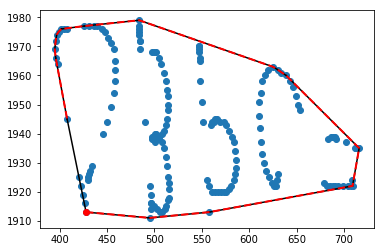

In [130]:
polygon_plot(abc.block_coordinates[7])

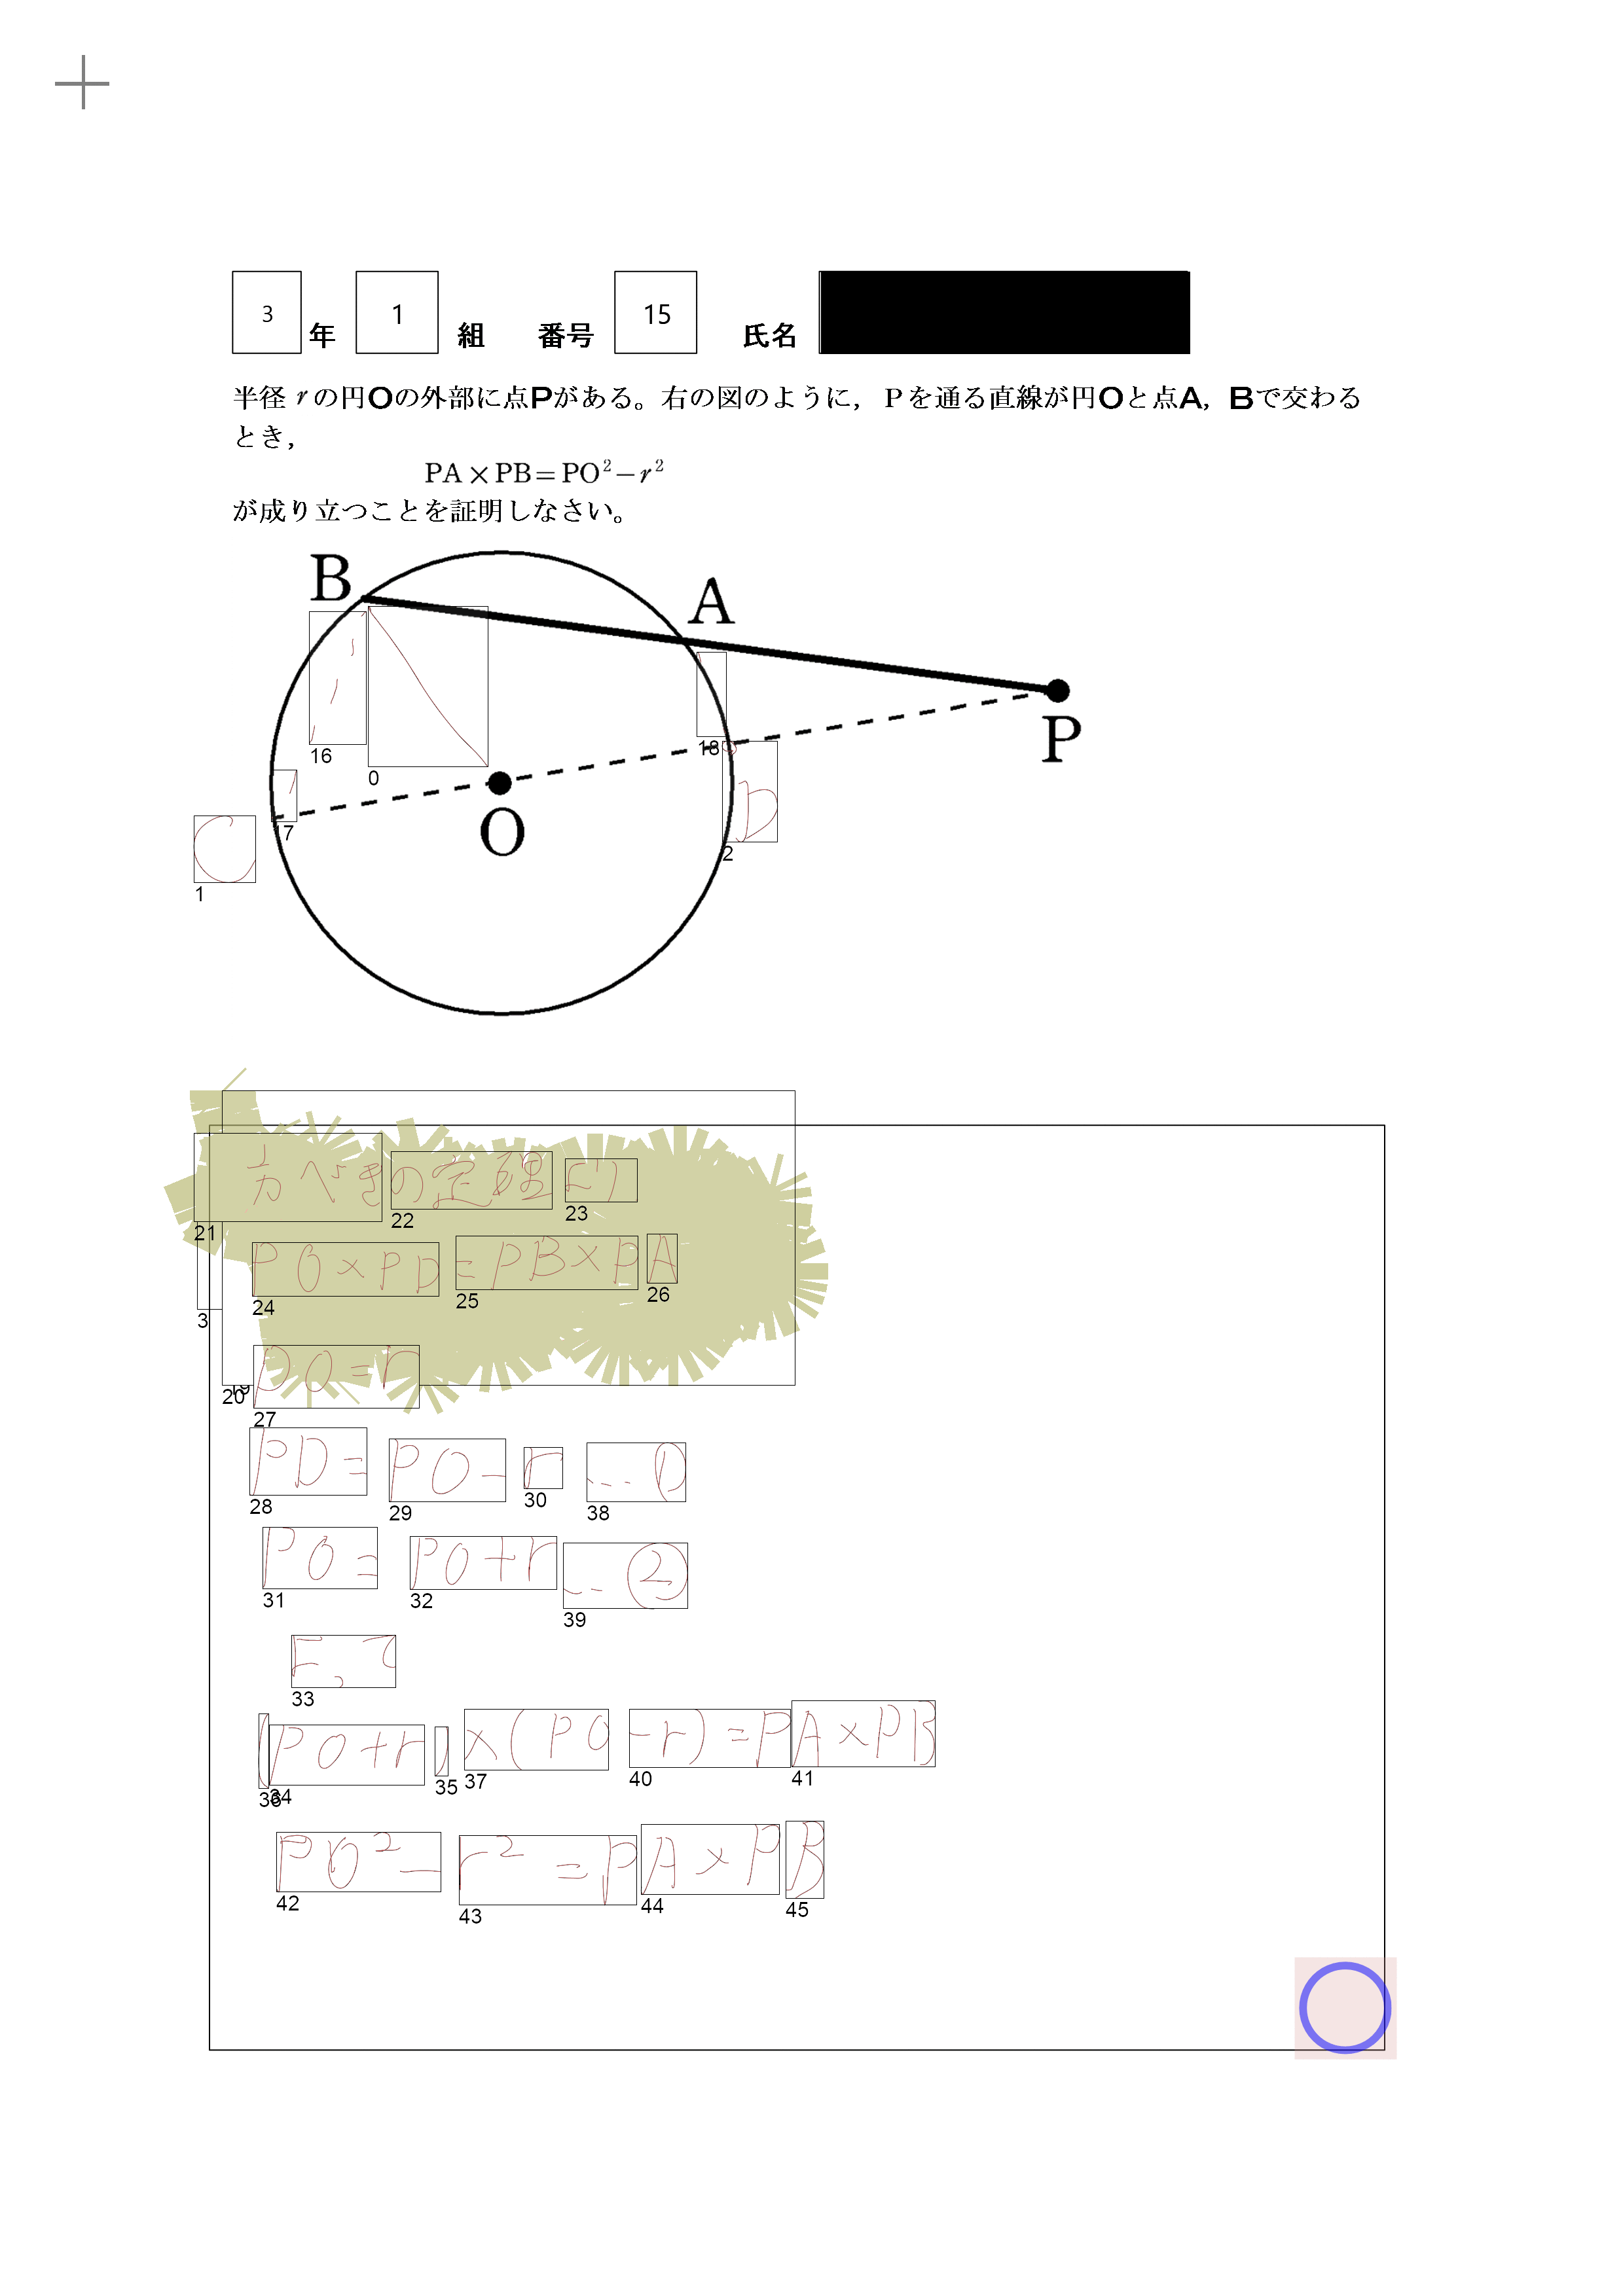

In [137]:

import PIL
imagename = "test/image" + filenum + ".gif"
image = PIL.Image.open(imagename)
overlayimage = abc.overlay_image(image)
overlayimage2 = abc.overlay_block_image(overlayimage)
overlayimage2


In [19]:

abc.get_feature_value()


0


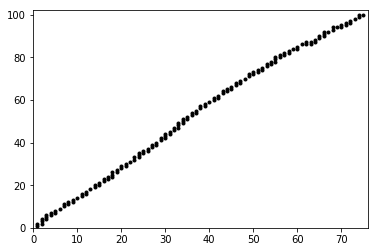

[ 0.          0.          0.02040816  0.08163265  0.          0.14285714
  0.          0.          0.          0.          0.          0.71428571
  0.02040816  0.02040816]
1


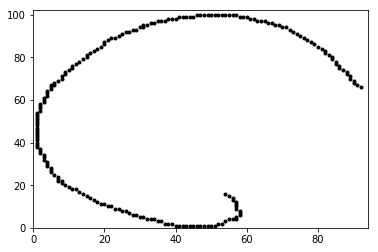

[ 0.          0.01020408  0.          0.00510204  0.51530612  0.46938776
  0.          0.          0.          0.          0.          0.          0.
  0.        ]
2


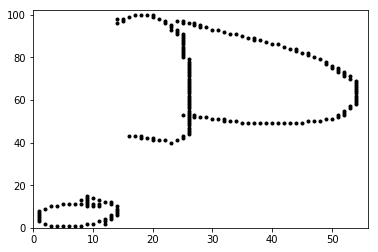

[ 0.          0.01212121  0.02424242  0.03030303  0.25454545  0.50909091
  0.          0.          0.          0.          0.00606061  0.11515152
  0.          0.04848485]
3


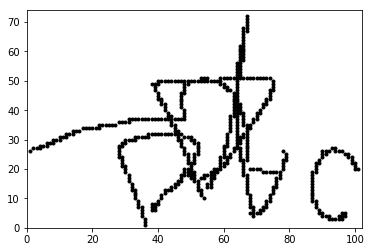

[ 0.          0.01807229  0.00301205  0.00903614  0.11144578  0.28313253
  0.          0.          0.          0.          0.0060241   0.21084337
  0.05722892  0.30120482]
4


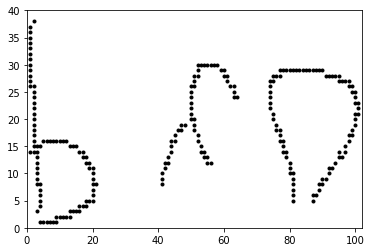

[ 0.         0.0390625  0.046875   0.046875   0.1640625  0.4765625  0.         0.
  0.         0.0078125  0.0078125  0.1796875  0.         0.03125  ]
5


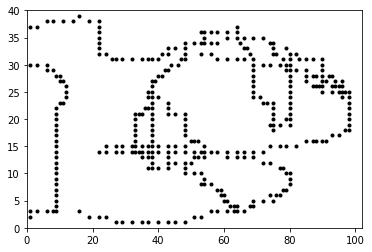

[ 0.22670807  0.23291925  0.06521739  0.04968944  0.07763975  0.19875776
  0.          0.          0.          0.01863354  0.00310559  0.05900621
  0.03416149  0.03416149]
6


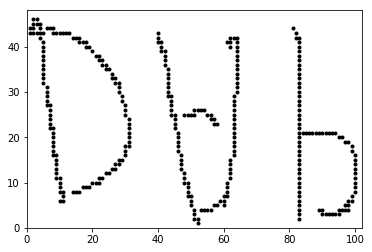

[ 0.          0.02714932  0.02714932  0.00904977  0.21719457  0.55656109
  0.          0.          0.          0.00452489  0.          0.10859729
  0.01809955  0.03167421]
7


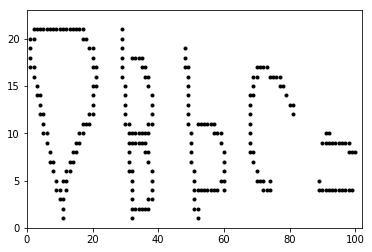

[ 0.          0.04794521  0.04794521  0.04109589  0.08219178  0.38356164
  0.          0.          0.          0.02054795  0.          0.25342466
  0.04109589  0.08219178]
8


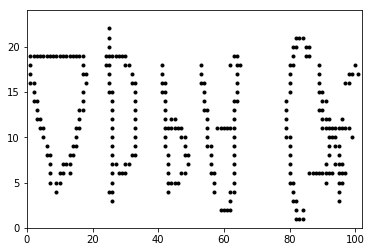

[ 0.          0.07317073  0.03658537  0.04268293  0.07926829  0.29878049
  0.          0.          0.          0.03658537  0.          0.26829268
  0.04268293  0.12195122]
9


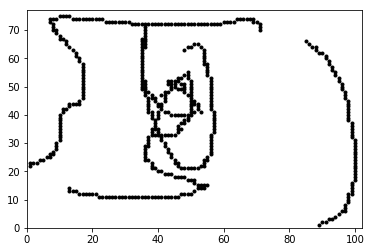

[ 0.          0.0127551   0.01020408  0.03571429  0.26785714  0.48214286
  0.          0.          0.          0.0127551   0.00765306  0.08418367
  0.0255102   0.06122449]
10


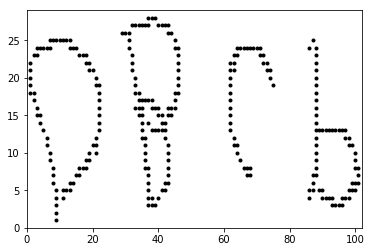

[ 0.          0.03424658  0.02739726  0.01369863  0.15068493  0.40410959
  0.          0.          0.          0.01369863  0.00684932  0.21917808
  0.04109589  0.0890411 ]
11


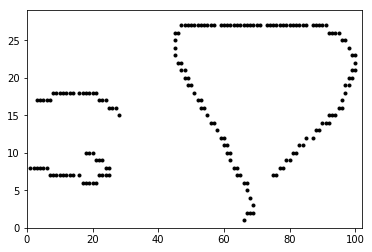

[ 0.          0.12328767  0.          0.03424658  0.26027397  0.48630137
  0.          0.          0.          0.          0.          0.07534247
  0.01369863  0.00684932]
12


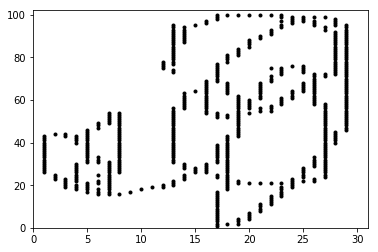

[ 0.          0.0020284   0.00608519  0.00811359  0.10141988  0.39350913
  0.          0.          0.          0.0040568   0.00608519  0.06896552
  0.07910751  0.3306288 ]
13


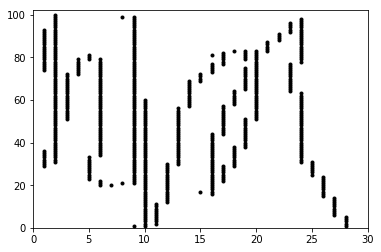

[ 0.          0.00830565  0.00498339  0.00332226  0.04152824  0.51162791
  0.          0.          0.          0.00332226  0.          0.02159468
  0.0282392   0.37707641]
14


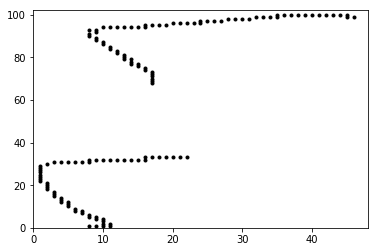

[ 0.          0.03448276  0.02298851  0.          0.34482759  0.50574713
  0.          0.          0.          0.          0.01149425  0.05747126
  0.01149425  0.01149425]
15


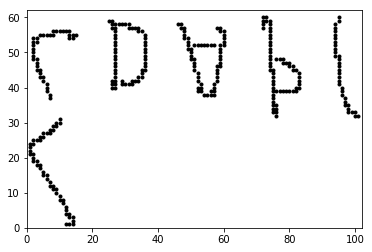

[ 0.          0.03448276  0.04022989  0.01724138  0.11494253  0.43678161
  0.          0.          0.          0.00574713  0.          0.23563218
  0.05172414  0.06321839]
16


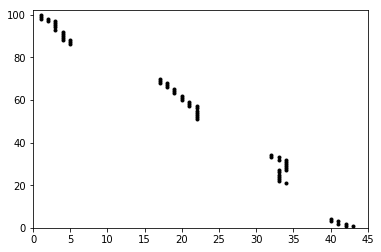

[ 0.          0.12820513  0.07692308  0.          0.23076923  0.38461538
  0.          0.          0.          0.          0.          0.17948718
  0.          0.        ]
17


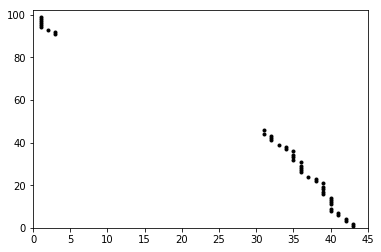

[ 0.02173913  0.43478261  0.          0.          0.26086957  0.2826087   0.
  0.          0.          0.          0.          0.          0.          0.        ]
18


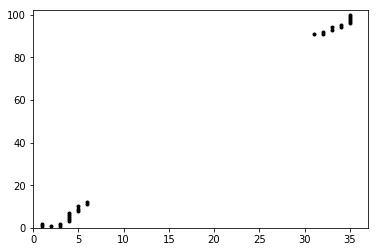

[ 0.          0.0952381   0.0952381   0.14285714  0.28571429  0.33333333
  0.          0.          0.          0.          0.          0.
  0.04761905  0.        ]
19


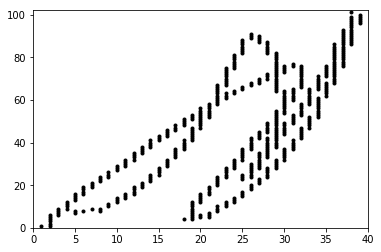

[ 0.          0.          0.01869159  0.00311526  0.10280374  0.26791277
  0.          0.          0.          0.          0.01246106  0.12461059
  0.08722741  0.38317757]
20


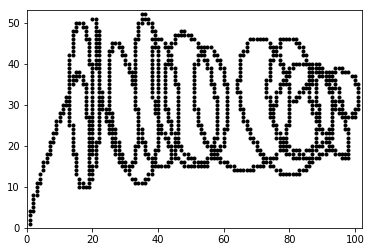

[ 0.          0.00146843  0.00146843  0.01174743  0.01615272  0.23788546
  0.          0.          0.          0.00146843  0.          0.21292217
  0.08516887  0.43171806]
21


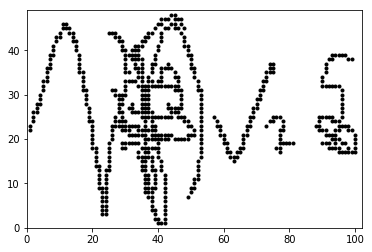

[ 0.          0.02051282  0.01282051  0.02564103  0.10512821  0.18461538
  0.          0.          0.          0.01025641  0.01025641  0.20769231
  0.04615385  0.37692308]
22


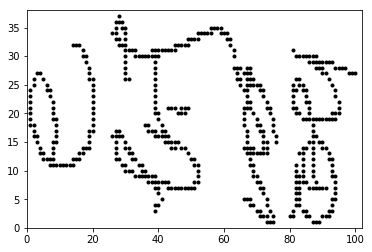

[ 0.          0.03135889  0.02090592  0.02439024  0.12195122  0.2195122   0.
  0.          0.          0.01393728  0.          0.28919861  0.05226481
  0.22648084]
23


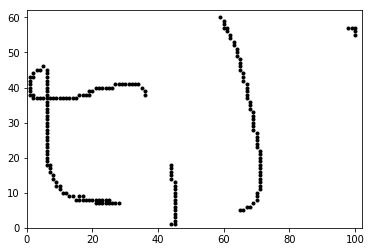

[ 0.          0.04320988  0.00617284  0.01851852  0.27777778  0.5308642   0.
  0.          0.          0.          0.          0.0617284   0.02469136
  0.03703704]
24


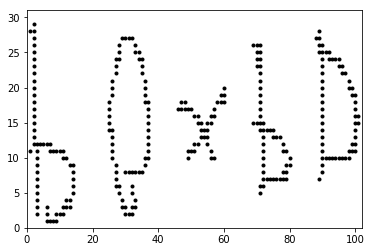

[ 0.          0.03825137  0.04371585  0.0273224   0.09289617  0.39344262
  0.          0.          0.          0.01092896  0.          0.20765027
  0.06557377  0.12021858]
25


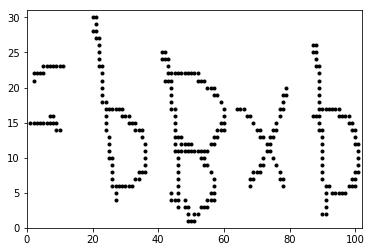

[ 0.          0.02906977  0.05813953  0.03488372  0.0872093   0.30813953
  0.          0.          0.          0.01162791  0.00581395  0.25581395
  0.06395349  0.14534884]
26


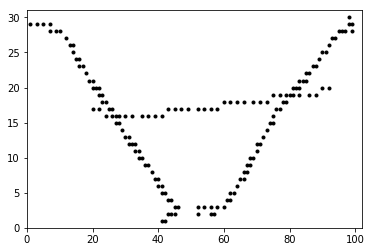

[ 0.30392157  0.12745098  0.03921569  0.03921569  0.15686275  0.08823529
  0.          0.          0.          0.          0.          0.2254902   0.
  0.01960784]
27


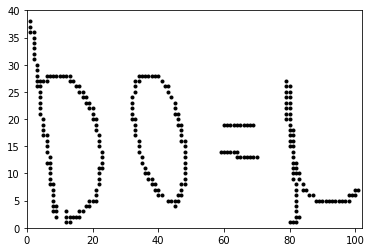

[ 0.          0.04242424  0.02424242  0.01818182  0.13939394  0.36363636
  0.          0.          0.          0.00606061  0.00606061  0.21818182
  0.06060606  0.12121212]


In [22]:

for block_num in range(len(abc.blocks)):
    if abc.stroke_or_string[block_num] == 0:
        print(block_num)
        grid_plot(abc.block_grid[block_num])
        print(abc.grid_feature[block_num]/np.sum(abc.grid_feature[block_num]))



In [268]:
print(abc.grid_feature)

[array([ 0,  2,  0,  0, 43, 47,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  4,  0,  0, 56, 83,  0,  0,  0,  0,  0,  0,  0,  0]), array([  0,  18,   5,   4, 184, 304,   0,   0,   0,   3,   1,  19,   4,  10]), array([  0,  33,   3,   7, 343, 463,   0,   0,   0,   3,   3,  11,   1,   2]), array([  0,  18,   0,   2, 189, 234,   0,   0,   0,   1,   1,  12,   2,   9]), array([  0,  17,   3,   4, 152, 203,   0,   0,   0,   3,   1,   4,   0,   0])]


In [2]:
x,y = 1,2
print(x)
print(y)

1
2


In [11]:
a = True

In [23]:
list1 = [0,3]
list2 = [1,3]
list3 = [0,2]
list4 = [4,10]

def checker(list1,list2,list3,list4):
    x1 = list1[0]
    y1 = list1[1]
    x2 = list2[0]
    y2 = list2[1]
    x3 = list3[0]
    y3 = list3[1]
    x4 = list4[0]
    y4 = list4[1]
    checker1 = (x1-x2)*(y3-y1) - (y1-y2)*(x3-x1)
    checker2 = (x1-x2)*(y4-y1) - (y1-y2)*(x4-x1)
    checker3 = (x4-x3)*(y1-y4) - (y4-y3)*(x1-x4)
    checker4 = (x4-x3)*(y2-y4) - (y4-y3)*(x2-x4)
    if checker1*checker2 <= 0 and checker3*checker4 <= 0:
        return True
    else:
        return False
    
checker(list1,list2,list3,list4)

True

In [35]:
for i in range(3,10):
    print(i)


3
4
5
6
7
8
9


In [39]:
a = [[],[]]
a[1].append(1)
print(a)

[[], [1]]


In [44]:
points = np.random.rand(30, 2)   # 30 random points in 2-D
print(points)
hull = ConvexHull(points)

[[ 0.46176628  0.59189461]
 [ 0.17406193  0.44993197]
 [ 0.48961997  0.45721411]
 [ 0.99376813  0.25969867]
 [ 0.94649841  0.2206722 ]
 [ 0.27199847  0.36792135]
 [ 0.16250252  0.9924227 ]
 [ 0.51391747  0.31929552]
 [ 0.08548347  0.01789238]
 [ 0.20111461  0.81855802]
 [ 0.32055993  0.39550644]
 [ 0.31167225  0.60443825]
 [ 0.41189939  0.34240476]
 [ 0.78407158  0.51761593]
 [ 0.4775822   0.84980254]
 [ 0.05512674  0.80073663]
 [ 0.77609107  0.80335327]
 [ 0.39059398  0.92720325]
 [ 0.32823432  0.67435175]
 [ 0.59733763  0.19352832]
 [ 0.67888483  0.2758254 ]
 [ 0.01191591  0.04877753]
 [ 0.67299406  0.77853561]
 [ 0.41762152  0.81469201]
 [ 0.90562641  0.78457022]
 [ 0.03881552  0.44686546]
 [ 0.38673244  0.14625221]
 [ 0.75424022  0.51068717]
 [ 0.38993279  0.56652679]
 [ 0.08451061  0.71003008]]


In [42]:
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

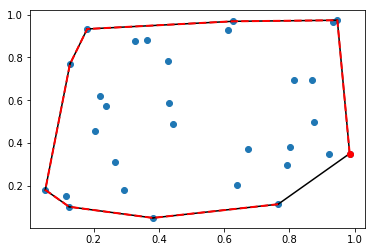

In [43]:
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

In [107]:
a = [np.empty((0,2)),np.empty((0,2))]
print(a)

[array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64)]


In [115]:
a[0] = np.append(a[0],np.array([[0,1]]),axis = 0)
print(a)

[array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]]), array([], shape=(0, 2), dtype=float64)]


In [97]:
a = np.empty((0,2))
np.append(a,np.array([[1,2]]), axis = 0)

array([[ 1.,  2.]])

In [96]:
c = np.empty((0,2))
print(c)

[]
